## Exploratory Data Analysis of MTA turnstile data

In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import inspect
from sqlalchemy import create_engine

### Use SQLAlchemy to import data from the SQLite tables into Python

In [3]:
engine = create_engine("sqlite:///mta_data.db")
inspector = inspect(engine)
all_tables = inspector.get_table_names()

In [4]:
all_tables

['mta_data']

In [5]:
mta_df=pd.read_sql('SELECT * FROM mta_data', engine)
mta_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,00:00:00,REGULAR,7589159,2594185
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,04:00:00,REGULAR,7589165,2594190
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,08:00:00,REGULAR,7589174,2594207
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,12:00:00,REGULAR,7589214,2594253
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,16:00:00,REGULAR,7589300,2594278
...,...,...,...,...,...,...,...,...,...,...,...
3354150,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,05:00:00,REGULAR,5554,541
3354151,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,09:00:00,REGULAR,5554,541
3354152,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,13:00:00,REGULAR,5554,541
3354153,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,17:00:00,REGULAR,5554,541


### Clean up the column names to keep it consistent

In [6]:
mta_df.columns = mta_df.columns.str.strip()
mta_df.columns = mta_df.columns.str.lower()
mta_df.columns

Index(['c/a', 'unit', 'scp', 'station', 'linename', 'division', 'date', 'time',
       'desc', 'entries', 'exits'],
      dtype='object')

### Create a new Datetime column to the data frame

In [7]:
mta_df["date_time"] = mta_df.date+' '+mta_df.time
mta_df["date_time"] = pd.to_datetime(mta_df["date_time"])

mta_df

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,00:00:00,REGULAR,7589159,2594185,2021-06-19 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,04:00:00,REGULAR,7589165,2594190,2021-06-19 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,08:00:00,REGULAR,7589174,2594207,2021-06-19 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,12:00:00,REGULAR,7589214,2594253,2021-06-19 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,16:00:00,REGULAR,7589300,2594278,2021-06-19 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
3354150,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,05:00:00,REGULAR,5554,541,2020-09-04 05:00:00
3354151,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,09:00:00,REGULAR,5554,541,2020-09-04 09:00:00
3354152,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,13:00:00,REGULAR,5554,541,2020-09-04 13:00:00
3354153,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,17:00:00,REGULAR,5554,541,2020-09-04 17:00:00


In [8]:
mta_df.drop_duplicates(subset=["c/a", "unit", "scp", "station", "date_time"], inplace=True)

## Calculate actual entries and exits from cumulative counts

In [9]:
mta_df['entries_r'] = mta_df.groupby(['c/a', 'unit', 'scp', 'station']).entries.diff(1)
mta_df['exits_r'] = mta_df.groupby(['c/a', 'unit', 'scp', 'station']).exits.diff(1)

## Clean the data by removing rows that have abnormal values of negative numbers or more than 10k

In [10]:
mta_df['entries_r'] = mta_df['entries_r'].apply(lambda x: 0 if (x<0 or x>10000) else x)
mta_df['exits_r'] = mta_df['exits_r'].apply(lambda x: 0 if (x<0 or x>10000) else x)

## Remove rows which have DESC other than REGULAR

In [11]:
mta_df.dropna(subset=['entries_r', 'exits_r'], inplace=True)

In [12]:
index_desc = mta_df[mta_df['desc'] == 'RECOVR AUD'].index
  
# drop these row indexes
# from dataFrame
mta_df.drop(index_desc, inplace = True)

In [13]:
mta_df

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time,entries_r,exits_r
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,04:00:00,REGULAR,7589165,2594190,2021-06-19 04:00:00,6.0,5.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,08:00:00,REGULAR,7589174,2594207,2021-06-19 08:00:00,9.0,17.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,12:00:00,REGULAR,7589214,2594253,2021-06-19 12:00:00,40.0,46.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,16:00:00,REGULAR,7589300,2594278,2021-06-19 16:00:00,86.0,25.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,20:00:00,REGULAR,7589434,2594298,2021-06-19 20:00:00,134.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3354150,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,05:00:00,REGULAR,5554,541,2020-09-04 05:00:00,0.0,0.0
3354151,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,09:00:00,REGULAR,5554,541,2020-09-04 09:00:00,0.0,0.0
3354152,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,13:00:00,REGULAR,5554,541,2020-09-04 13:00:00,0.0,0.0
3354153,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,17:00:00,REGULAR,5554,541,2020-09-04 17:00:00,0.0,0.0


## Calculate foot traffic as the sum of entries and exits in each station

In [14]:
mta_df['foot_traffic'] = mta_df['entries_r']+mta_df['exits_r']
mta_df

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time,entries_r,exits_r,foot_traffic
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,04:00:00,REGULAR,7589165,2594190,2021-06-19 04:00:00,6.0,5.0,11.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,08:00:00,REGULAR,7589174,2594207,2021-06-19 08:00:00,9.0,17.0,26.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,12:00:00,REGULAR,7589214,2594253,2021-06-19 12:00:00,40.0,46.0,86.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,16:00:00,REGULAR,7589300,2594278,2021-06-19 16:00:00,86.0,25.0,111.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/19/2021,20:00:00,REGULAR,7589434,2594298,2021-06-19 20:00:00,134.0,20.0,154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3354150,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,05:00:00,REGULAR,5554,541,2020-09-04 05:00:00,0.0,0.0,0.0
3354151,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,09:00:00,REGULAR,5554,541,2020-09-04 09:00:00,0.0,0.0,0.0
3354152,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,13:00:00,REGULAR,5554,541,2020-09-04 13:00:00,0.0,0.0,0.0
3354153,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/04/2020,17:00:00,REGULAR,5554,541,2020-09-04 17:00:00,0.0,0.0,0.0


## Group by station to find the top 15 busiest stations

In [15]:
mta_top15 = mta_df.groupby(["station"]).agg({'foot_traffic':sum}).sort_values("foot_traffic", ascending=False).head(15)
mta_top15 = mta_top15.reset_index()
mta_top15

,station,foot_traffic
0,34 ST-PENN STA,8112131.0
1,34 ST-HERALD SQ,6512066.0
2,86 ST,6021667.0
3,125 ST,5750096.0
4,GRD CNTRL-42 ST,5641827.0
5,14 ST-UNION SQ,5478584.0
6,23 ST,5052545.0
7,42 ST-PORT AUTH,5049267.0
8,FLUSHING-MAIN,4472033.0
9,59 ST,4364954.0


## Use Seaborn to plot the graph of the busiest stations based on foot traffic

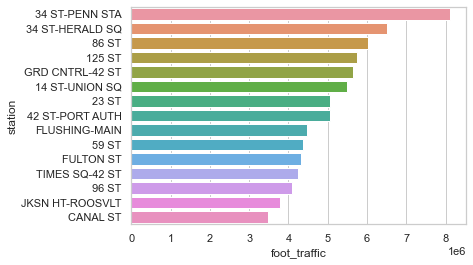

In [16]:
sns.set_theme(style="whitegrid")
ax=sns.barplot(data=mta_top15, y='station', x='foot_traffic')
fig = ax.get_figure()
fig.savefig('NYC Coffee Location.png')

## Create a column for the day of the week

In [17]:
mta_df['month']= pd.DatetimeIndex(mta_df['date_time']).month

In [18]:
mta_df['weekday']= (mta_df['date_time']).dt.weekday

In [19]:
weekdays = [0,1,2,3,4,5,6]
mta_df['weekday'] = pd.Categorical(mta_df['weekday'], categories=weekdays, ordered = True)

In [20]:
wkday = mta_df[['weekday','foot_traffic']].groupby('weekday').sum().reset_index()
wkday

,weekday,foot_traffic
0,0,50377871.0
1,1,55971915.0
2,2,56800796.0
3,3,55276687.0
4,4,55288115.0
5,5,37436561.0
6,6,30522544.0


## Create a Bar plot using Matplotlib to find the traffic pattern on Weekdays vs Weekends

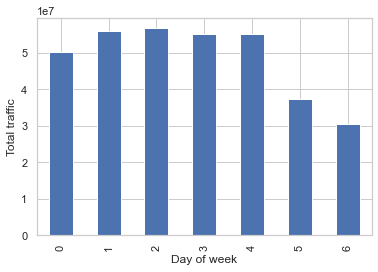

In [21]:
fig, ax = plt.subplots()
p = wkday['foot_traffic'].plot(kind='bar', ax=ax)
ax.set_xlabel('Day of week')
ax.set_ylabel('Total traffic')
plt.show()

## Identify 42 ST as a suitable station for a coffee shop location based on its traffic

In [22]:
mta_pa = mta_df[mta_df['station']=='42 ST-PORT AUTH']
mta_pa.sort_values('foot_traffic', ascending=False).tail(10)

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time,entries_r,exits_r,foot_traffic,month,weekday
2779941,N062,R011,01-03-03,42 ST-PORT AUTH,ACENQRS1237W,IND,09/15/2020,04:00:00,REGULAR,5406405,4936317,2020-09-15 04:00:00,0.0,0.0,0.0,9,1
2779940,N062,R011,01-03-03,42 ST-PORT AUTH,ACENQRS1237W,IND,09/15/2020,00:00:00,REGULAR,5406405,4936317,2020-09-15 00:00:00,0.0,0.0,0.0,9,1
2779939,N062,R011,01-03-03,42 ST-PORT AUTH,ACENQRS1237W,IND,09/14/2020,20:00:00,REGULAR,5406405,4936317,2020-09-14 20:00:00,0.0,0.0,0.0,9,0
2779938,N062,R011,01-03-03,42 ST-PORT AUTH,ACENQRS1237W,IND,09/14/2020,16:00:00,REGULAR,5406405,4936317,2020-09-14 16:00:00,0.0,0.0,0.0,9,0
2779937,N062,R011,01-03-03,42 ST-PORT AUTH,ACENQRS1237W,IND,09/14/2020,12:00:00,REGULAR,5406405,4936317,2020-09-14 12:00:00,0.0,0.0,0.0,9,0
2779936,N062,R011,01-03-03,42 ST-PORT AUTH,ACENQRS1237W,IND,09/14/2020,08:00:00,REGULAR,5406405,4936317,2020-09-14 08:00:00,0.0,0.0,0.0,9,0
2779935,N062,R011,01-03-03,42 ST-PORT AUTH,ACENQRS1237W,IND,09/14/2020,04:00:00,REGULAR,5406405,4936317,2020-09-14 04:00:00,0.0,0.0,0.0,9,0
2779934,N062,R011,01-03-03,42 ST-PORT AUTH,ACENQRS1237W,IND,09/14/2020,00:00:00,REGULAR,5406405,4936317,2020-09-14 00:00:00,0.0,0.0,0.0,9,0
2779933,N062,R011,01-03-03,42 ST-PORT AUTH,ACENQRS1237W,IND,09/13/2020,20:00:00,REGULAR,5406405,4936317,2020-09-13 20:00:00,0.0,0.0,0.0,9,6
3200984,N063A,R011,00-05-01,42 ST-PORT AUTH,ACENQRS1237W,IND,09/04/2020,20:00:00,REGULAR,589824,88,2020-09-04 20:00:00,0.0,0.0,0.0,9,4


## Create dataframes for different seasons of the year

In [23]:
mta_fall = mta_pa[mta_pa['month']==9]
mta_winter= mta_pa[mta_pa['month']==12]
mta_spring = mta_pa[mta_pa['month']==3]
mta_summer=mta_pa[mta_pa['month']==6]

In [24]:
mta_daytime = mta_fall[['station', 'date_time', 'foot_traffic']].groupby(['station', 'date_time'], as_index=False).foot_traffic.sum()

In [25]:
mta_daytime = mta_daytime.set_index('date_time')
mta_daytime = mta_daytime.resample('2H', convention='end').sum()
mta_daytime = mta_daytime.reset_index()
mta_daytime

,date_time,foot_traffic
0,2020-09-01 00:00:00,2451.0
1,2020-09-01 02:00:00,1005.0
2,2020-09-01 04:00:00,160.0
3,2020-09-01 06:00:00,284.0
4,2020-09-01 08:00:00,6385.0
...,...,...
295,2020-09-25 14:00:00,2850.0
296,2020-09-25 16:00:00,7585.0
297,2020-09-25 18:00:00,4669.0
298,2020-09-25 20:00:00,10208.0


In [26]:
mta_daytime['day'] = mta_daytime['date_time'].dt.dayofweek
mta_daytime['time'] = mta_daytime['date_time'].dt.time

In [27]:
mta_daytime = mta_daytime.groupby(['day', 'time']).foot_traffic.mean().reset_index()
mta_daytime.tail(10)

,day,time,foot_traffic
74,6,04:00:00,239.333333
75,6,06:00:00,80.000000
76,6,08:00:00,951.333333
77,6,10:00:00,928.000000
78,6,12:00:00,2920.000000
79,6,14:00:00,1623.000000
80,6,16:00:00,3373.333333
81,6,18:00:00,2392.666667
82,6,20:00:00,3911.333333
83,6,22:00:00,1978.000000


## Create a heatmap using Seaborn to find the busiest times of the day

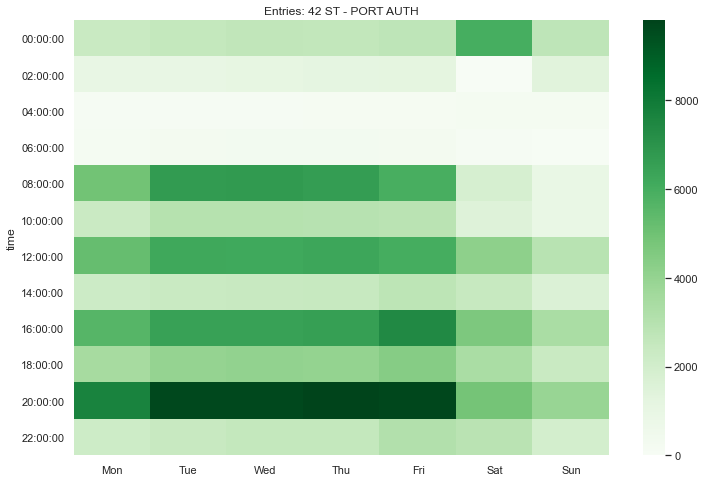

In [28]:
heatmap_pa = mta_daytime.set_index(['day', 'time']).foot_traffic.unstack(0)

weekdays = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
heatmap_pa.columns = [weekdays[n] for n in heatmap_pa.columns]
fig, ax = plt.subplots(figsize=(12,8))
ax.set(title='Entries: 42 ST - PORT AUTH', xlabel='', ylabel='Time')
sns.heatmap(heatmap_pa,ax=ax, cmap='Greens')
#sns.lineplot(data=mta_daytime, x='day', y='foot_traffic')
plt.show()

## Create lineplots to see the change in traffic based on different seasons

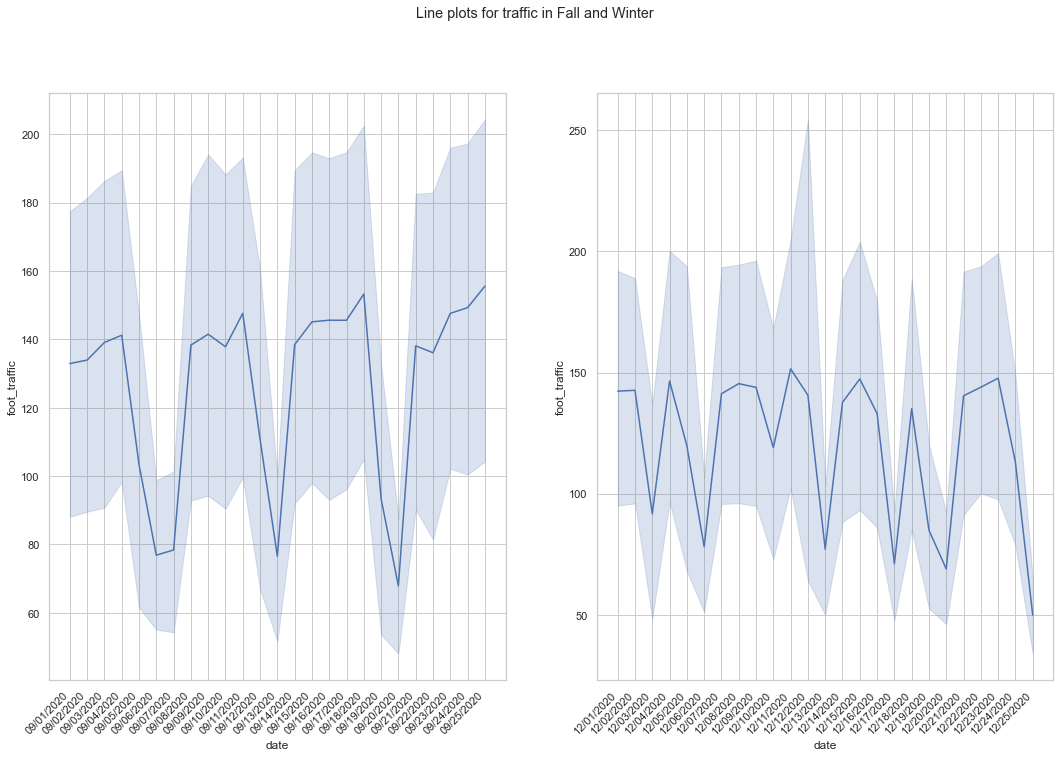

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

fig.suptitle('Line plots for traffic in Fall and Winter')

sns.lineplot(ax=axes[0], data=mta_fall.groupby(['date','time']).foot_traffic.mean().reset_index(), x='date', y='foot_traffic')
sns.lineplot(ax=axes[1], data=mta_winter.groupby(['date','time']).foot_traffic.mean().reset_index(), x='date', y='foot_traffic')

fig.autofmt_xdate(rotation=45)

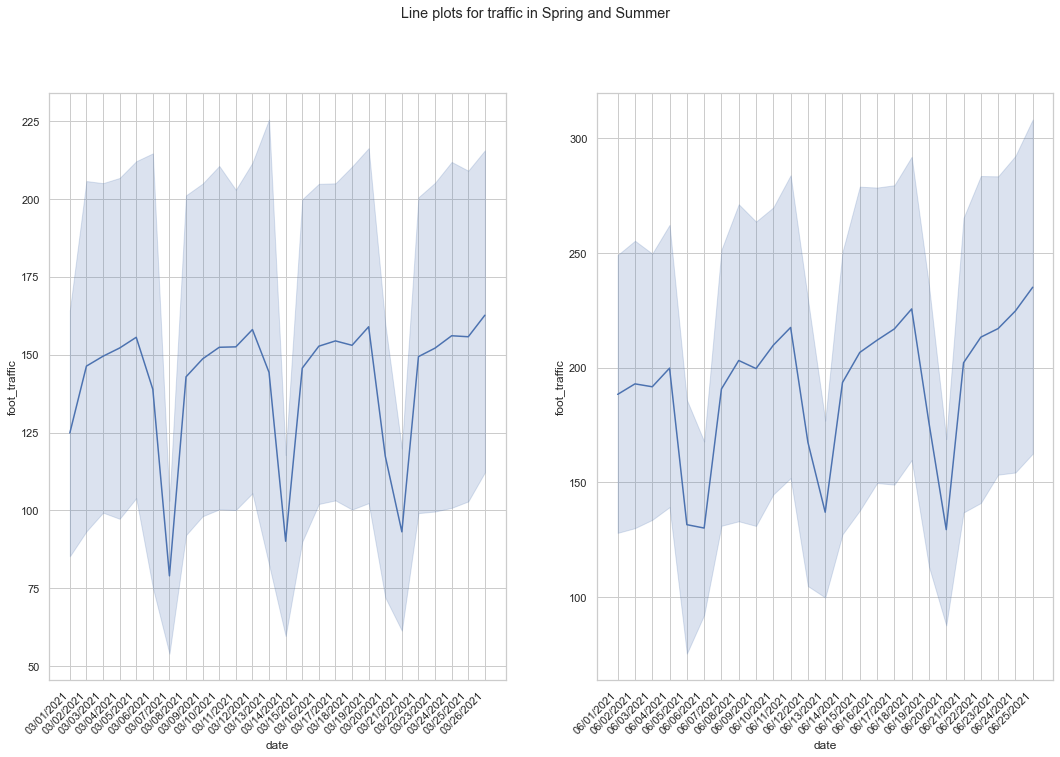

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

fig.suptitle('Line plots for traffic in Spring and Summer')

sns.lineplot(ax=axes[0], data=mta_spring.groupby(['date','time']).foot_traffic.mean().reset_index(), x='date', y='foot_traffic')
sns.lineplot(ax=axes[1], data=mta_summer.groupby(['date','time']).foot_traffic.mean().reset_index(), x='date', y='foot_traffic')

fig.autofmt_xdate(rotation=45)